In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers 
import matplotlib.pyplot as plt
print(f'Tensorflow version: {tf.__version__}')
print(f'Eager execution: {tf.executing_eagerly()}')

Tensorflow version: 2.1.0
Eager execution: True


### Data path

In [2]:
train_dir = 'C:\\Users\\shuxg\\.keras\\datasets\\iris_training.csv'
test_dir = 'C:\\Users\\shuxg\\.keras\\datasets\\iris_test.csv'

### Load data

In [3]:
df = pd.read_csv(train_dir)
print(df.shape)
df.head(3)

(120, 5)


,120,4,setosa,versicolor,virginica
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2


In [4]:
# rename columns
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
column_features = column_names[:-1]
column_label = column_names[-1]
print(f'Feature columns: {column_features}')
print(f'Label column: {column_label}')

Feature columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label column: species


In [5]:
BATCH_SIZE = 32
train_ds = tf.data.experimental.make_csv_dataset(file_pattern=train_dir,
                                                 batch_size=BATCH_SIZE,
                                                 column_names=column_names,
                                                 label_name=column_label,
                                                 num_epochs=1)

test_ds = tf.data.experimental.make_csv_dataset(file_pattern=test_dir,
                                                batch_size=BATCH_SIZE,
                                                column_names=column_names,
                                                label_name=column_label,
                                                shuffle=False,
                                                num_epochs=1)

In [6]:
x, y = next(iter(train_ds))
x

OrderedDict([('sepal_length',
              <tf.Tensor: shape=(32,), dtype=float32, numpy=
              array([4.6, 5.3, 4.9, 6.2, 6.4, 5. , 4.7, 6.5, 6.7, 6.1, 5.8, 6.1, 5.1,
                     6.5, 4.9, 6. , 5.5, 4.8, 4.5, 4.8, 5.8, 4.4, 5.2, 5.4, 5.7, 6.9,
                     4.7, 7.7, 6.6, 5.1, 7.7, 6.4], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: shape=(32,), dtype=float32, numpy=
              array([3.1, 3.7, 2.4, 2.2, 2.8, 2.3, 3.2, 3. , 3.3, 2.6, 2.6, 2.9, 3.8,
                     3. , 3.1, 3. , 2.6, 3. , 2.3, 3.4, 2.7, 3. , 2.7, 3.9, 4.4, 3.1,
                     3.2, 3.8, 2.9, 3.8, 2.8, 3.2], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: shape=(32,), dtype=float32, numpy=
              array([1.5, 1.5, 3.3, 4.5, 5.6, 3.3, 1.6, 5.2, 5.7, 5.6, 4. , 4.7, 1.6,
                     5.5, 1.5, 4.8, 4.4, 1.4, 1.3, 1.6, 4.1, 1.3, 3.9, 1.3, 1.5, 4.9,
                     1.3, 6.7, 4.6, 1.5, 6.7, 5.3], dtype=float32)>),
  

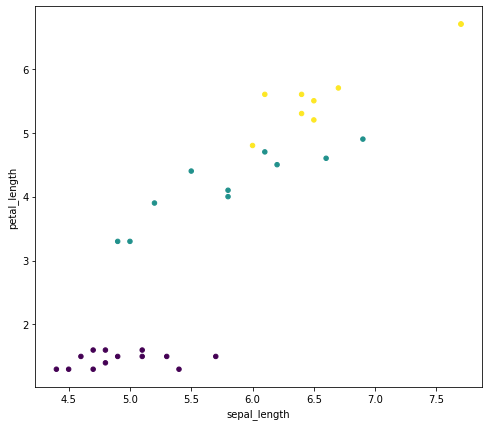

In [7]:
plt.figure(figsize=(8, 7))
plt.scatter(x['sepal_length'], x['petal_length'], c=y, s=20)
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.show()

In [8]:
def map_func(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

train_ds = train_ds.map(map_func)
test_ds = test_ds.map(map_func)

x, y = next(iter(train_ds))
x[0:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[6.5, 3. , 5.5, 1.8],
       [6.4, 3.2, 5.3, 2.3],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.9, 1.3, 0.4],
       [5.7, 2.9, 4.2, 1.3],
       [5.7, 4.4, 1.5, 0.4],
       [6.5, 3.2, 5.1, 2. ],
       [4.4, 3.2, 1.3, 0.2],
       [5.8, 2.8, 5.1, 2.4],
       [5.9, 3. , 5.1, 1.8]], dtype=float32)>

### Classifier

In [9]:
# method 1
model = tf.keras.Sequential([layers.Dense(10, activation='relu'),
                             layers.Dense(10, activation='relu'),
                             layers.Dense(3, activation='softmax')])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for epoch in range(201):
    history = model.fit(train_ds, epochs=1, validation_data=test_ds, verbose=0)
    if epoch % 50 == 0:
        template = 'Epoch {}, Loss {:.3f}, Acc {:.2f}, Val_loss {:.3f}, Val_acc {:.2f}'
        print(template.format(epoch+1,
                              history.history['loss'][-1],
                              history.history['accuracy'][-1],
                              history.history['val_loss'][-1], 
                              history.history['val_accuracy'][-1]))

Epoch 1, Loss 1.264, Acc 0.28, Val_loss 1.164, Val_acc 0.40
Epoch 51, Loss 0.666, Acc 0.72, Val_loss 0.746, Val_acc 0.57
Epoch 101, Loss 0.320, Acc 0.98, Val_loss 0.366, Val_acc 0.97
Epoch 151, Loss 0.182, Acc 0.98, Val_loss 0.197, Val_acc 0.97
Epoch 201, Loss 0.122, Acc 0.98, Val_loss 0.127, Val_acc 0.97


In [10]:
# method 2
class Model(tf.keras.Model):
    
    def __init__(self, unit_list, num_classes):
        super(Model, self).__init__()
        self.d1 = layers.Dense(unit_list[0])
        self.d2 = layers.Dense(unit_list[1])
        self.d3 = layers.Dense(num_classes)
    
    def call(self, x):
        x = self.d1(x)
        x = tf.nn.relu(x)
        x = self.d2(x)
        x = tf.nn.relu(x)
        x = self.d3(x)
        return x

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Metrics
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# def accuracy_func(y, prediction):
#     y_hat = tf.argmax(tf.nn.softmax(prediction), axis=1, output_type=tf.int32)
#     return tf.reduce_mean(tf.cast(tf.equal(y, y_hat), tf.float32))

# Train step
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss(loss), train_accuracy(y, predictions)

# Test step
def test_step(model, x, y):
    predictions = model(x, training=False)
    loss = loss_object(y, predictions)
    return test_loss(loss), test_accuracy(y, predictions)

In [11]:
model = Model([10, 10], 3)
Epochs = 201
for epoch in range(Epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for x, y in train_ds:
        train_step(model, x, y)
    
    for x, y in test_ds:
        test_step(model, x, y)
    
    if epoch % 50 == 0:
        template = 'Epoch {}, Loss {:.3f}, Acc {:.2f}, Val_loss {:.3f}, Val_acc {:.2f}'
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result()*100,
                              test_loss.result(),
                              test_accuracy.result()*100))

Epoch 1, Loss 1.213, Acc 35.00, Val_loss 1.236, Val_acc 26.67
Epoch 51, Loss 0.667, Acc 75.00, Val_loss 0.723, Val_acc 60.00
Epoch 101, Loss 0.289, Acc 93.33, Val_loss 0.360, Val_acc 93.33
Epoch 151, Loss 0.180, Acc 96.67, Val_loss 0.211, Val_acc 90.00
Epoch 201, Loss 0.124, Acc 96.67, Val_loss 0.140, Val_acc 96.67
